

[Doc to refer](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)



In [1]:
!pip install pyLDAvis
# ==2.1.2
!pip install vaderSentiment
!pip install pandas==1.2.0
!pip install gensim==3.8.3
#!pip install gensim_models

In [2]:
import numpy as np
import gzip
import glob
import pandas as pd
import nltk
from pprint import pprint

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis as pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

2022-01-03 15:48:03.306960: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-03 15:48:03.307086: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Cell_Phones_and_Accessories_5.json.gz')
df = df[['reviewText']]
print(df.head())

                                          reviewText
0  They look good and stick good! I just don't li...
1  These stickers work like the review says they ...
2  These are awesome and make my phone look so st...
3  Item arrived in great time and was in perfect ...
4  awesome! stays on, and looks great. can be use...


In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['reviewText']))

print(data_words[:1])

[['they', 'look', 'good', 'and', 'stick', 'good', 'just', 'don', 'like', 'the', 'rounded', 'shape', 'because', 'was', 'always', 'bumping', 'it', 'and', 'siri', 'kept', 'popping', 'up', 'and', 'it', 'was', 'irritating', 'just', 'won', 'buy', 'product', 'like', 'this', 'again']]


In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['they', 'look', 'good', 'and', 'stick', 'good', 'just', 'don', 'like', 'the', 'rounded', 'shape', 'because', 'was', 'always', 'bumping', 'it', 'and', 'siri', 'kept', 'popping', 'up', 'and', 'it', 'was', 'irritating', 'just', 'won', 'buy', 'product', 'like', 'this', 'again']


In [6]:
# #TF-IDF REMOVAL
# from gensim.models import TfidfModel

# id2word = corpora.Dictionary(data_bigrams_trigrams)

# texts = data_bigrams_trigrams

# corpus = [id2word.doc2bow(text) for text in texts]
# # print (corpus[0][0:20])

# tfidf = TfidfModel(corpus, id2word=id2word)

# low_value = 0.03
# words  = []
# words_missing_in_tfidf = []
# for i in range(0, len(corpus)):
#     bow = corpus[i]
#     low_value_words = [] #reinitialize to be safe. You can skip this.
#     tfidf_ids = [id for id, value in tfidf[bow]]
#     bow_ids = [id for id, value in bow]
#     low_value_words = [id for id, value in tfidf[bow] if value < low_value]
#     drops = low_value_words+words_missing_in_tfidf
#     for item in drops:
#         words.append(id2word[item])
#     words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

#     new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
#     corpus[i] = new_bow

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/mimi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# initiate stopwords from nltk

stop_words = stopwords.words('english')

# add additional missing terms

#stop_words.extend(stop_words_list) 

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['look', 'good', 'stick', 'good', 'rounded', 'shape', 'always', 'bump', 'siri', 'keep', 'pop', 'irritate', 'buy', 'product']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]]


In [12]:
id2word[0]

'always'

In [13]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('always', 1),
  ('bump', 1),
  ('buy', 1),
  ('good', 2),
  ('irritate', 1),
  ('keep', 1),
  ('look', 1),
  ('pop', 1),
  ('product', 1),
  ('rounded', 1),
  ('shape', 1),
  ('siri', 1),
  ('stick', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.287*"galaxy" + 0.166*"pocket" + 0.097*"super" + 0.096*"hear" + '
  '0.074*"strong" + 0.067*"sleek" + 0.063*"become" + 0.052*"single" + '
  '0.044*"backup" + 0.016*"compliment"'),
 (1,
  '0.437*"charge" + 0.195*"charger" + 0.139*"port" + 0.071*"car" + '
  '0.050*"cord" + 0.031*"amp" + 0.028*"light" + 0.017*"wall" + 0.011*"fast" + '
  '0.008*"socket"'),
 (2,
  '0.150*"iphone" + 0.121*"review" + 0.080*"buy" + 0.069*"still" + '
  '0.056*"ipad" + 0.048*"bit" + 0.046*"hand" + 0.043*"far" + 0.040*"leave" + '
  '0.035*"perfectly"'),
 (3,
  '0.512*"cable" + 0.097*"connect" + 0.071*"rubber" + 0.070*"almost" + '
  '0.064*"quickly" + 0.052*"durable" + 0.046*"soft" + 0.015*"fail" + '
  '0.013*"complain" + 0.012*"limited"'),
 (4,
  '0.273*"plug" + 0.143*"apple" + 0.140*"easily" + 0.106*"clear" + '
  '0.070*"picture" + 0.065*"help" + 0.043*"multiple" + 0.034*"key" + '
  '0.025*"beautiful" + 0.021*"deliver"'),
 (5,
  '0.076*"use" + 0.049*"device" + 0.045*"get" + 0.041*"work" + 0.030*"time" +

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -15.446708101338457

Coherence Score:  0.30065002904093313


In [17]:
#  Visualize the topics
# pyLDAvis.enable_notebook()
# vis = gensimvis.prepare(lda_model, corpus, id2word)
# pyLDavis.display(vis)

In [18]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = gensimvis.prepare(lda_model, corpus, id2word)
# vis

In [19]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

Picked up _JAVA_OPTIONS: -Dawt.useSystemAAFontSettings=on -Dswing.aatext=true
Picked up _JAVA_OPTIONS: -Dawt.useSystemAAFontSettings=on -Dswing.aatext=true
Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 2200
total tokens: 6227539
<10> LL/token: -9.86268
<20> LL/token: -9.22699
<30> LL/token: -8.67912
<40> LL/token: -8.3605

0	2.5	work phone time cell good problem issue thing find make run long stay set great fine home pretty easy signal 
1	2.5	great love price buy product phone recommend good work item purchase nice iphone order color money fit friend worth happy 
2	2.5	feel nice stylus work make note tip hand pen touch great good clip pocket rubber type small end write bit 
3	2.5	phone great iphone good make fit love buy work easy feel product purchase put time give perfect recommend nice back 
4	2.5	phone app camera android feature device mobile htc fast call video photo smartphone keyboard user datum play droid support nokia 
5	2.5	phone update watch 

<150> LL/token: -7.57215
<160> LL/token: -7.56098
<170> LL/token: -7.5533
<180> LL/token: -7.54598
<190> LL/token: -7.54115

0	2.5	work time problem fine find issue cell long lose start run home couple set stay thing year month leave put 
1	2.5	great work product recommend price buy highly friend fast good item quality excellent beat job describe easy quickly family purchase 
2	2.5	feel make nice hand pocket small stylus touch easy tip pen bit size carry find type end big rubber easily 
3	2.5	phone iphone drop put make protect easy time damage back wife lot worry safe change save job accidentally switch everyday 
4	2.5	phone app android camera feature call video htc screen mobile fast device service play keyboard droid picture smartphone plan user 
5	2.5	review issue read update find problem make contact time watch people thing experience give change star day start receive mention 
6	2.5	product purchase galaxy give note star price happy buy brand quality good expect nexus cheap expens

<310> LL/token: -7.50429
<320> LL/token: -7.50157
<330> LL/token: -7.49915
<340> LL/token: -7.49681

0	2.5	work time problem fine find issue cell long month start couple year lose home run week stay set stop leave 
1	2.5	great work product price recommend good highly easy item quality fast buy job beat excellent describe quickly family advertise quick 
2	2.5	feel make small pocket hand nice stylus easy touch size tip pen carry easily find bit end type rubber large 
3	2.5	phone protect put drop make easy time back damage lot worry job safe fall smart iphone save wife change pop 
4	2.5	phone app android camera call feature video htc screen mobile fast device service play keyboard smartphone nokia user update picture 
5	2.5	review issue read update problem find star contact give make time receive people watch company experience mention send back thing 
6	2.5	product purchase note galaxy give quality price good star expect happy brand nexus high make expensive excellent cheap year buy 
7	2

<450> LL/token: -7.47877
<460> LL/token: -7.47743
<470> LL/token: -7.47715
<480> LL/token: -7.47571
<490> LL/token: -7.47351

0	2.5	work time problem fine find issue long month start year couple lose run home week stay set leave stop happen 
1	2.5	great work product recommend price good highly easy item fast job beat describe quickly advertise excellent family quality perfect durable 
2	2.5	feel make small pocket hand nice stylus easy touch size tip pen carry easily find bit large end type rubber 
3	2.5	phone protect drop put cell make easy back damage time worry fall safe smart lot job save problem pop add 
4	2.5	phone app android camera call feature video screen htc mobile device fast service play keyboard update smartphone picture nokia photo 
5	2.5	review issue star give read update problem receive find make contact company experience send mention back time decide reason people 
6	2.5	good quality price galaxy note purchase give product expect high star happy nexus brand cheap make

<600> LL/token: -7.46175
<610> LL/token: -7.46255
<620> LL/token: -7.46244
<630> LL/token: -7.46179
<640> LL/token: -7.46071

0	2.5	work time problem fine issue find long month start couple year lose week home stay run set leave stop signal 
1	2.5	great product work recommend price easy highly item good fast job describe perfect quickly purchase advertise perfectly excellent pleased expect 
2	2.5	feel small make pocket hand nice easy stylus touch size tip pen carry easily find end large type bit rubber 
3	2.5	phone protect drop put make cell easy back damage time worry job fall lot smart safe save problem bulky pop 
4	2.5	phone app android camera feature call video screen htc mobile fast service device play keyboard update smartphone picture photo nokia 
5	2.5	review star give issue read update receive problem make contact find reason company experience mention send back free decide hope 
6	2.5	good price quality galaxy note purchase expect high give cheap nexus excellent brand happy e

<750> LL/token: -7.45547
<760> LL/token: -7.45468
<770> LL/token: -7.45445
<780> LL/token: -7.45356
<790> LL/token: -7.45242

0	2.5	work time problem fine find issue month long start year couple lose home week run stay set leave stop happen 
1	2.5	great product work recommend easy price item highly purchase fast job quickly describe perfectly advertise perfect happy pleased expect excellent 
2	2.5	feel small make pocket nice hand easy stylus touch size tip pen carry easily large bit end find type weight 
3	2.5	phone protect drop put cell make easy back damage time worry fall lot smart job safe save pop wife problem 
4	2.5	phone app android camera feature call video screen htc mobile fast device update service play keyboard smartphone picture watch user 
5	2.5	review star give issue read update receive make problem find reason contact company experience send decide mention hope back free 
6	2.5	good price quality galaxy note expect cheap high excellent nexus give purchase expensive bran

<900> LL/token: -7.45177
<910> LL/token: -7.45298
<920> LL/token: -7.45184
<930> LL/token: -7.45155
<940> LL/token: -7.45024

0	2.5	work time problem find issue long month fine start year couple lose home week run stay leave set stop happen 
1	2.5	great product work recommend easy item purchase highly price job fine quickly fast describe happy advertise perfect perfectly pleased complaint 
2	2.5	small feel make pocket nice hand easy stylus size touch tip pen carry easily find large bit end type give 
3	2.5	phone protect drop put make cell easy back damage time fall worry job smart save lot safe pop bulky lg 
4	2.5	phone app android camera feature call video screen htc mobile fast device service update keyboard watch play smartphone photo user 
5	2.5	review star give issue read update receive problem find make reason contact company decide back experience send mention hope version 
6	2.5	good price quality galaxy note expect cheap high excellent nexus buy expensive brand give low worth 

In [20]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(15,
  [('sound', 0.04947960867115206),
   ('headset', 0.04415009538810398),
   ('bluetooth', 0.0341745138374985),
   ('ear', 0.03303166704007206),
   ('speaker', 0.028711479839503576),
   ('call', 0.028073296083316927),
   ('headphone', 0.023750845819783244),
   ('music', 0.02218028012193383),
   ('pair', 0.018767581170410906),
   ('quality', 0.01809092534381584)]),
 (2,
  [('small', 0.04407886295921422),
   ('feel', 0.042072362324832135),
   ('make', 0.04099605114972843),
   ('nice', 0.03347612870115614),
   ('pocket', 0.033319315152465535),
   ('hand', 0.03126291929804553),
   ('easy', 0.030033358518539638),
   ('stylus', 0.027239226196416097),
   ('touch', 0.02508303990192025),
   ('size', 0.024751593083096924)]),
 (11,
  [('hold', 0.05819910059298974),
   ('place', 0.03088390115268056),
   ('stand', 0.022138732017745966),
   ('fall', 0.01750379237623063),
   ('clip', 0.01738943247215841),
   ('stay', 0.014930694534605644),
   ('holster', 0.013935090663859243),
   ('car', 0.013444

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [22]:
#Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

Picked up _JAVA_OPTIONS: -Dawt.useSystemAAFontSettings=on -Dswing.aatext=true
Picked up _JAVA_OPTIONS: -Dawt.useSystemAAFontSettings=on -Dswing.aatext=true
Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 2200
total tokens: 6227539
<10> LL/token: -7.72102
<20> LL/token: -7.67472
<30> LL/token: -7.50759
<40> LL/token: -7.40608

0	25	case phone screen good fit protector make cover easy button feel quality great sound back protect headset put protection hard 
1	25	charge phone battery work great charger device product time iphone buy cable power good price long love day port plug 

<50> LL/token: -7.34421
<60> LL/token: -7.30593
<70> LL/token: -7.28
<80> LL/token: -7.25989
<90> LL/token: -7.24632

0	25	case phone screen good fit protector make easy love great cover feel button back put quality nice sound protect color 
1	25	charge work phone battery time product charger device great iphone buy cable power day long port plug car review price 

<100> LL/token: -7.23

<50> LL/token: -7.76166
<60> LL/token: -7.66866
<70> LL/token: -7.60802
<80> LL/token: -7.56748
<90> LL/token: -7.54001

0	6.25	charge battery charger device cable power port plug light time ipad pack hour unit tablet iphone micro full apple small 
1	6.25	buy great price product purchase good order work cheap recommend love day month time item week worth happy money receive 
2	6.25	screen protector easy make put scratch remove edge bubble feel stylus touch good clear side back apply glass install clean 
3	6.25	case protect iphone color protection cover drop feel phone hard button add back plastic rubber black otterbox nice white grip 
4	6.25	phone fit love great good hold nice put perfect make perfectly fall pocket easy recommend pretty break big easily clip 
5	6.25	work product car iphone make long give great note review star thing cord find time problem fine issue nice place 
6	6.25	quality sound headset good bluetooth ear call button speaker music volume headphone pair hear turn set

<450> LL/token: -7.42932
<460> LL/token: -7.42895
<470> LL/token: -7.42858
<480> LL/token: -7.42814
<490> LL/token: -7.42825

0	6.25	charge battery charger device cable power port plug light ipad time pack hour apple tablet unit micro full review small 
1	6.25	buy product price purchase work order good cheap time great day item month week receive worth happy break recommend money 
2	6.25	screen protector easy make put remove scratch bubble feel touch stylus clear edge good apply back glass install clean side 
3	6.25	case cover protect protection drop feel iphone hard button back plastic add phone rubber black otterbox color white thin provide 
4	6.25	phone great fit love good nice recommend perfect color perfectly easy galaxy pretty fall put pocket lot cute clip awesome 
5	6.25	work iphone make hold car thing long problem fine star place give find issue time cord bit note stand dock 
6	6.25	sound quality headset good bluetooth ear call button speaker music volume headphone pair turn he

<850> LL/token: -7.42907
<860> LL/token: -7.43025
<870> LL/token: -7.42933
<880> LL/token: -7.42886
<890> LL/token: -7.4291

0	6.25	charge battery charger device cable power port plug light ipad time pack hour apple tablet unit micro iphone full mah 
1	6.25	product buy price work purchase order time cheap day item good month week receive break worth expect money give quality 
2	6.25	screen protector easy make put scratch feel bubble touch remove stylus clear edge good apply back glass install clean pen 
3	6.25	case cover protection protect drop phone feel hard iphone button back plastic add rubber otterbox black fit pocket white thin 
4	6.25	phone great fit love good nice recommend color perfect buy perfectly easy galaxy pretty lot highly job cute awesome put 
5	6.25	work iphone make hold car thing problem place fine long bit find put time stand issue stay give big cord 
6	6.25	sound quality headset good bluetooth ear call button speaker music volume headphone pair hear turn set wear d

<150> LL/token: -7.52397
<160> LL/token: -7.51268
<170> LL/token: -7.50472
<180> LL/token: -7.49724
<190> LL/token: -7.48885

0	3.57143	battery time charge day long hour life full leave extra run work original turn quickly start week fully couple light 
1	3.57143	iphone fit nice color love perfect perfectly black white pretty picture cute feel case show blue order pink super red 
2	3.57143	great buy good price love recommend purchase happy quality friend highly awesome job wife fast amazing worth gift beat husband 
3	3.57143	sound headset bluetooth ear quality call speaker headphone volume music pair hear good device set button wear comfortable control connect 
4	3.57143	app android camera feature device phone video htc user update mobile fast smartphone watch call photo version good support display 
5	3.57143	cover button back feel plastic side hard make top front bottom part piece bit rubber press face hand easily edge 
6	3.57143	review star receive give order issue amazon product pr

<400> LL/token: -7.44078
<410> LL/token: -7.43978
<420> LL/token: -7.4392
<430> LL/token: -7.43999
<440> LL/token: -7.44002

0	3.57143	battery time charge day long hour life full leave light run extra turn fully quickly start minute original week night 
1	3.57143	iphone fit love nice color perfect perfectly black white pretty easy picture cute show blue super order cool pink red 
2	3.57143	great buy good price recommend love quality purchase happy friend highly awesome worth cheap job wife fast amazing gift beat 
3	3.57143	sound headset bluetooth ear call speaker quality headphone music volume pair hear good set device wear comfortable button control connect 
4	3.57143	app android camera feature device video htc update call mobile user phone fast find smartphone version watch photo support display 
5	3.57143	cover button back feel plastic hard side make top front bottom part rubber piece bit press hand material soft face 
6	3.57143	product review order receive star amazon give purchase

<650> LL/token: -7.42959
<660> LL/token: -7.42916
<670> LL/token: -7.42914
<680> LL/token: -7.42855
<690> LL/token: -7.42817

0	3.57143	battery charge time day long hour life light pack full leave run extra fully turn minute mah carry heavy night 
1	3.57143	iphone love fit color nice perfect perfectly black white picture easy pretty cute super order blue pink cool show red 
2	3.57143	buy good great price recommend quality cheap purchase worth product happy friend highly money pay job awesome expensive fast amazing 
3	3.57143	sound headset bluetooth ear call speaker quality headphone music volume pair hear set good button comfortable wear turn control device 
4	3.57143	phone app android camera feature device htc update video call mobile user fast find smartphone watch version service support photo 
5	3.57143	cover button back feel plastic hard side make top front bottom part rubber piece bit press hand easily material face 
6	3.57143	product review order receive star amazon purchase giv

<900> LL/token: -7.4257
<910> LL/token: -7.42483
<920> LL/token: -7.42411
<930> LL/token: -7.42451
<940> LL/token: -7.42433

0	3.57143	battery charge time day long hour pack light life full leave power run fully mah extra turn minute heavy carry 
1	3.57143	iphone love fit color nice perfect perfectly black white picture great cute easy pretty order super blue show pink cool 
2	3.57143	buy good price great recommend product cheap quality purchase worth money friend highly pay happy job excellent expensive store fast 
3	3.57143	sound headset bluetooth ear call speaker quality headphone music volume pair hear set good button comfortable control turn wear device 
4	3.57143	phone app android camera feature htc video call update device mobile user fast find version watch smartphone service home support 
5	3.57143	cover button feel back plastic hard side make top front bottom part rubber bit piece hand nice press soft material 
6	3.57143	product review order receive star week purchase amazon 

<100> LL/token: -7.6986
<110> LL/token: -7.66549
<120> LL/token: -7.63748
<130> LL/token: -7.61769
<140> LL/token: -7.60017

0	2.5	product price buy item cheap purchase order worth money pay arrive expect cost ship store shipping brand package describe receive 
1	2.5	note make small feel stylus size hand touch tip large pen find nice galaxy type big bit end weight design 
2	2.5	love buy great recommend perfect friend purchase cute happy highly fit awesome super order wife color perfectly daughter absolutely gift 
3	2.5	good quality price phone pretty easy galaxy excellent make lot thing nexus job feel recommend high year great happy buy 
4	2.5	work great fine buy time month good price recommend job phone problem water complaint lot expect perfectly couple advertise easy 
5	2.5	battery day time charge hour long life full run leave extra original anker heavy fully turn night spare extend die 
6	2.5	hold phone place stand side easy stay put holder close card open car stick make fall mount

<250> LL/token: -7.51212
<260> LL/token: -7.50945
<270> LL/token: -7.50683
<280> LL/token: -7.50519
<290> LL/token: -7.50323

0	2.5	product buy order item purchase cheap worth price money pay arrive cost amazon ship store break brand receive seller expect 
1	2.5	note make small stylus galaxy size feel hand touch find tip large pen type big bit end weight give nice 
2	2.5	love buy great recommend perfect purchase friend highly cute awesome happy super wife absolutely daughter amazing gift durable husband order 
3	2.5	good price quality nice pretty easy feel excellent job expect high great make cheap recommend lot nexus build beat decent 
4	2.5	work great time fine month buy problem long product couple year replace week complaint galaxy water perfectly advertise job lose 
5	2.5	battery day charge time hour long life full run leave extra fully anker original heavy turn extend spare night die 
6	2.5	hold place stand easy side put stay open holder car close phone make card stick fall remove

<400> LL/token: -7.49156
<410> LL/token: -7.49127
<420> LL/token: -7.49088
<430> LL/token: -7.48995
<440> LL/token: -7.48941

0	2.5	product buy order purchase item cheap money worth pay price arrive amazon cost ship seller break receive store brand package 
1	2.5	note make small galaxy stylus feel size touch hand find tip large pen type bit big end nice design weight 
2	2.5	love great buy recommend perfect friend highly purchase cute awesome happy super absolutely daughter amazing gift durable husband wife son 
3	2.5	good price quality nice great pretty easy feel expect excellent job high cheap recommend lot nexus beat build make give 
4	2.5	work great time fine month buy problem long year product couple replace galaxy week perfectly complaint wife advertise happy lose 
5	2.5	battery day charge time hour long life full run leave extra anker fully heavy turn original spare night extend die 
6	2.5	hold place stand side stay put open car holder easy card fall stick close remove make mount

<550> LL/token: -7.48707
<560> LL/token: -7.48626
<570> LL/token: -7.48574
<580> LL/token: -7.48481
<590> LL/token: -7.48396

0	2.5	product order buy purchase item cheap money worth pay price amazon arrive cost receive break seller ship store brand shipping 
1	2.5	note make small galaxy feel stylus hand size touch find tip large pen big bit type end nice give weight 
2	2.5	love great buy recommend perfect friend highly awesome cute purchase super happy amazing daughter absolutely durable gift husband wife son 
3	2.5	good price quality product great nice pretty easy expect excellent job recommend high feel cheap nexus beat decent give lot 
4	2.5	work great time fine buy month problem long year couple replace week wife complaint happy galaxy ago advertise purchase lose 
5	2.5	battery day charge time hour long life full run leave extra anker fully heavy turn original night extend spare die 
6	2.5	hold place stand put side car easy stay holder open close card stick make fall remove mount a

<700> LL/token: -7.47921
<710> LL/token: -7.47978
<720> LL/token: -7.47992
<730> LL/token: -7.48032
<740> LL/token: -7.47989

0	2.5	buy order purchase item cheap product worth money pay amazon price arrive break cost seller receive brand ship store shipping 
1	2.5	note make small feel stylus galaxy hand size touch find tip large pen type bit big end weight nice give 
2	2.5	love great buy recommend perfect friend highly awesome cute super purchase happy absolutely amazing daughter gift husband durable fast son 
3	2.5	good price product quality great nice easy excellent recommend job expect pretty high nexus cheap give beat decent build feel 
4	2.5	work great time fine month problem buy long year couple week replace wife complaint happy purchase perfectly lose ago advertise 
5	2.5	battery day charge time hour long life full run leave extra anker fully heavy turn original spare night extend die 
6	2.5	hold place stand car side open stay put holder easy make card stick fall close mount rem

<850> LL/token: -7.48021
<860> LL/token: -7.47984
<870> LL/token: -7.479
<880> LL/token: -7.47949
<890> LL/token: -7.47814

0	2.5	buy order purchase item cheap worth money pay product amazon break arrive price cost seller brand receive ship store shipping 
1	2.5	note make feel small stylus hand size galaxy touch find tip pen large bit type nice big end weight give 
2	2.5	love great buy recommend perfect friend highly awesome cute purchase super happy amazing daughter absolutely durable gift husband fast wife 
3	2.5	good product price quality great recommend excellent job easy nice expect pretty high nexus cheap beat decent give build expensive 
4	2.5	work great time fine month problem buy long year couple week replace complaint wife purchase happy lose ago perfectly advertise 
5	2.5	battery day charge time hour long life full run leave extra fully anker heavy turn original spare extend night die 
6	2.5	hold place stand car side stay open put holder close card easy stick remove fall mak

<1000> LL/token: -7.47731

Total time: 7 minutes 31 seconds
Picked up _JAVA_OPTIONS: -Dawt.useSystemAAFontSettings=on -Dswing.aatext=true
Picked up _JAVA_OPTIONS: -Dawt.useSystemAAFontSettings=on -Dswing.aatext=true
Mallet LDA: 26 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 2200
total tokens: 6227539
<10> LL/token: -10.08042
<20> LL/token: -9.32005
<30> LL/token: -8.77446
<40> LL/token: -8.45731

0	1.92308	case button protection feel add grip slim provide side bumper edge bulk back press tpu design cutout drop material fit 
1	1.92308	product work good buy great price item purchase give time quality brand recommend expect receive phone make package star cheap 
2	1.92308	iphone great fit nice good phone love recommend price work easy black perfect buy perfectly make product put give bit 
3	1.92308	great product work buy price good love recommend quality item time purchase friend cheap gift highly worth excellent receive phone 
4	1.92308	work time problem find car thin

<150> LL/token: -7.64961
<160> LL/token: -7.6382
<170> LL/token: -7.62741
<180> LL/token: -7.61817
<190> LL/token: -7.61001

0	1.92308	case button feel add protection grip slim bulk provide bumper material press thin hand tpu slippery surface back soft cutout 
1	1.92308	product order item purchase receive expect arrive recommend fast seller happy ship package quickly describe shipping packaging quality amazon satisfied 
2	1.92308	iphone nice easy good make design apple give great ipod simple easily wife sleek sturdy extra recommend lot build excellent 
3	1.92308	great price work recommend good quality highly awesome friend beat buy amazing product excellent deal job family fantastic wonderful charm 
4	1.92308	work problem time fine issue find start lose thing turn stop couple long happen figure leave complaint constantly suppose annoying 
5	1.92308	battery charge power hour pack mah light full fully life day recharge capacity time external lead anker unit bank juice 
6	1.92308	note gal

<300> LL/token: -7.55091
<310> LL/token: -7.54913
<320> LL/token: -7.54841
<330> LL/token: -7.54639
<340> LL/token: -7.54418

0	1.92308	case feel add button protection slim grip bulk provide thin hand bumper material offer tpu slippery back scratch slip texture 
1	1.92308	product order item purchase receive expect fast arrive recommend seller happy ship package quickly shipping describe packaging satisfied quick pleased 
2	1.92308	iphone easy make nice design good apple give ipod easily simple great lot build sleek extra wife solid feel accessory 
3	1.92308	great price good recommend work quality highly friend awesome product beat amazing excellent job deal buy family fantastic durable reasonable 
4	1.92308	work problem time fine issue find start couple long complaint stop lose happen figure turn suppose fix trouble properly week 
5	1.92308	battery charge power hour pack light mah full life day fully recharge capacity time external lead unit anker bank portable 
6	1.92308	note galaxy m

0	1.92308	case feel protection add slim grip bulk provide thin material bumper offer hand scratch back tpu slippery slip protect texture 
1	1.92308	product order item purchase receive expect fast arrive happy recommend seller ship package shipping quickly describe packaging quick satisfied pleased 
2	1.92308	iphone make easy nice design apple good give ipod lot simple easily extra build great sleek accessory pro product solid 
3	1.92308	great price good recommend quality work highly product friend awesome excellent beat amazing job deal durable family fantastic wonderful buy 
4	1.92308	work problem time fine issue find long start complaint stop couple figure happen lose suppose properly hope trouble fix advertise 
5	1.92308	battery charge power hour pack light mah full life fully day time recharge capacity external lead unit anker bank portable 
6	1.92308	note galaxy make big feel nexus version high htc compare quality difference huge build issue give hand large notice bit 
7	1.92308	c

<100> LL/token: -7.79443
<110> LL/token: -7.75792
<120> LL/token: -7.72751
<130> LL/token: -7.70416
<140> LL/token: -7.68613

0	1.5625	stylus touch small tip pen make feel hand size type nice end ipad find tablet finger write long lose large 
1	1.5625	hold place car stand clip holster holder mount fall stay stick arm strong attach secure position belt securely magnet move 
2	1.5625	phone cell put make smart cradle problem wife back worry hold droid time verizon safe pop afraid stable pick alarm_clock 
3	1.5625	headset ear call sound bluetooth hear talk quality comfortable pair voice end wear answer clear volume people earpiece unit bud 
4	1.5625	headphone good wear run set stay design long fit find head wire earbud bit small size band sit quality earphone 
5	1.5625	speaker sound music device bluetooth play pair connect volume audio quality listen control turn car unit set bass stereo loud 
6	1.5625	side back top edge bottom front cut remove camera face line place piece surface hole lea

<200> LL/token: -7.61666
<210> LL/token: -7.6106
<220> LL/token: -7.60351
<230> LL/token: -7.59858
<240> LL/token: -7.59454

0	1.5625	stylus touch small tip pen make find type hand size end ipad long finger tablet feel write nice lose give 
1	1.5625	hold car place stand clip holster holder mount fall stick stay strong attach secure position drive arm belt securely magnet 
2	1.5625	phone cell make put smart worry pop back plan wife lg hold problem afraid barely pick hang safe everytime handle 
3	1.5625	headset ear call sound bluetooth hear talk quality pair comfortable voice end wear answer people clear volume earpiece bud mic 
4	1.5625	headphone good run wear set stay long find head bit earbud wire small time design size fit sit band move 
5	1.5625	sound speaker music device bluetooth play connect pair volume audio quality listen control turn unit set stereo range bass car 
6	1.5625	back side top front edge bottom cut camera face place line hole remove surface clear corner part piece l

<300> LL/token: -7.57607
<310> LL/token: -7.57321
<320> LL/token: -7.57078
<330> LL/token: -7.56959
<340> LL/token: -7.56769

0	1.5625	stylus small touch make tip pen find type hand size end long ipad lose tablet finger write large nice pocket 
1	1.5625	hold place car stand clip holster holder mount fall stay stick strong attach secure position drive belt remove securely dash 
2	1.5625	phone cell put make smart worry back plan lg wife pop anymore afraid handle flip suggest barely mytouch rarely lg_optimus 
3	1.5625	headset ear call sound bluetooth hear talk quality comfortable pair voice wear end answer volume clear people unit earpiece bud 
4	1.5625	headphone good run wear stay set find long head earbud wire time bit small problem move size sit band large 
5	1.5625	sound speaker music device bluetooth play pair quality volume audio connect listen control turn unit bass stereo set car range 
6	1.5625	back side top front edge bottom cut face camera line hole place clear remove corner su

<400> LL/token: -7.56039
<410> LL/token: -7.56051
<420> LL/token: -7.55873
<430> LL/token: -7.55692
<440> LL/token: -7.55606

0	1.5625	stylus small make tip pen touch find type size end hand ipad long lose finger tablet write large handy nice 
1	1.5625	hold car place stand clip holster holder mount fall stick strong stay attach position secure remove belt drive securely move 
2	1.5625	phone cell put smart make worry plan lg wife back flip pop anymore handle suggest afraid mytouch barely lg_optimus rarely 
3	1.5625	headset ear call sound bluetooth hear talk quality pair comfortable voice end wear answer people clear earpiece volume feature bud 
4	1.5625	headphone good run wear stay set find long head earbud small wire bit time place thing size fall problem big 
5	1.5625	sound speaker music device bluetooth play pair volume audio connect quality listen control turn unit set stereo bass range loud 
6	1.5625	back side top front edge bottom cut face camera line hole place clear surface corn

<500> LL/token: -7.55329
<510> LL/token: -7.55245
<520> LL/token: -7.55328
<530> LL/token: -7.55261
<540> LL/token: -7.55264

0	1.5625	stylus small make tip pen touch size find type end hand ipad long lose finger tablet write large handy work 
1	1.5625	hold car place stand clip holster holder mount fall stay stick strong attach position secure remove belt drive move securely 
2	1.5625	phone cell put make smart back worry plan lg pop handle anymore constantly safe wife mytouch flip rarely pick afraid 
3	1.5625	headset ear call sound bluetooth hear talk quality comfortable pair voice end wear answer clear people unit earpiece bud volume 
4	1.5625	headphone good run stay wear set find long time head small earbud bit wire put problem place fall pretty size 
5	1.5625	sound speaker music bluetooth device play pair volume quality audio connect listen control turn unit set stereo range bass headphone 
6	1.5625	back side top front edge bottom cut camera face line clear hole place slightly surfa

<600> LL/token: -7.54821
<610> LL/token: -7.54812
<620> LL/token: -7.54867
<630> LL/token: -7.54723
<640> LL/token: -7.54694

0	1.5625	stylus small make tip pen touch size find type end hand long ipad finger large tablet lose write work handy 
1	1.5625	hold car place stand clip holster holder mount fall stick stay strong attach position secure drive move belt securely remove 
2	1.5625	phone cell make put smart back plan lg worry pop safe pick handle downside constantly flip barely mytouch afraid anymore 
3	1.5625	headset ear call sound bluetooth hear talk quality comfortable pair voice end wear answer clear people unit earpiece bud feature 
4	1.5625	headphone run stay good wear set long find time small bit head put earbud wire lose thing big move lot 
5	1.5625	sound speaker music bluetooth device headphone pair play volume audio quality connect listen control turn set range stereo unit bass 
6	1.5625	back side top front edge bottom cut camera face line place hole clear corner slightly 

<700> LL/token: -7.54519
<710> LL/token: -7.54486
<720> LL/token: -7.54485
<730> LL/token: -7.54398
<740> LL/token: -7.54341

0	1.5625	stylus small make tip pen touch find size type end hand ipad long finger nice write tablet lose work large 
1	1.5625	hold car place stand clip holster holder mount fall stick stay strong position remove attach secure drive belt move securely 
2	1.5625	phone cell put make smart back plan worry lg safe handle pop rarely entire suggest pick afraid mytouch lg_optimus constantly 
3	1.5625	headset ear call sound bluetooth hear talk quality comfortable voice pair wear end answer people clear unit earpiece feature bud 
4	1.5625	stay run wear good time find headphone long set small bit put head pocket place big lose thing lot earbud 
5	1.5625	sound speaker music bluetooth headphone device pair play quality volume audio connect listen control turn set stereo unit range bass 
6	1.5625	back side top front bottom edge cut face camera line hole clear place slightly s

<800> LL/token: -7.5405
<810> LL/token: -7.54149
<820> LL/token: -7.54112
<830> LL/token: -7.54089
<840> LL/token: -7.54012

0	1.5625	stylus small make tip pen touch size type find end ipad hand long large finger tablet write lose handy nice 
1	1.5625	hold car place stand clip holster holder mount stick fall stay position strong attach remove secure belt move dash drive 
2	1.5625	phone cell put make back smart plan lg worry handle downside anymore wife safe pop constantly barely lg_optimus mytouch act 
3	1.5625	headset ear call sound bluetooth hear talk comfortable quality pair voice wear end answer people unit clear earpiece bud feature 
4	1.5625	time stay run wear long good find put set small pocket bit lose thing place head lot leave big fall 
5	1.5625	sound speaker music headphone bluetooth device pair play quality audio volume listen connect control set turn stereo range bass loud 
6	1.5625	back side top front bottom edge cut face camera line hole clear place slightly surface corn

<900> LL/token: -7.53805
<910> LL/token: -7.53795
<920> LL/token: -7.53759
<930> LL/token: -7.53711
<940> LL/token: -7.53738

0	1.5625	stylus small make tip pen touch size type find end hand long ipad finger large write tablet work nice handy 
1	1.5625	hold car place stand clip holster holder mount stick fall strong attach position stay remove secure belt move dash securely 
2	1.5625	phone cell put make back smart plan lg worry wife handle anymore safe barely mytouch act constantly suggest rarely tmobile 
3	1.5625	headset ear call sound bluetooth hear talk comfortable quality pair voice wear end answer earbud people clear unit set earpiece 
4	1.5625	time stay run long find wear put pocket good small bit lose place set leave big thing lot fall sit 
5	1.5625	sound speaker music headphone bluetooth device pair play quality volume audio listen connect control set turn stereo range bass loud 
6	1.5625	back side top front bottom edge cut face camera line place hole clear slightly surface cor

29	1.5625	phone galaxy note nexus make big version htc watch model find compare difference large size huge droid verizon upgrade decide 
30	1.5625	cable cord plug charge micro adapter long connector apple short end connect include standard lightning pin connection computer wireless length 
31	1.5625	color black white picture light show blue nice cute love pink red bright match beautiful pretty favorite change dark dirty 

<1000> LL/token: -7.53572

Total time: 3 hours 55 minutes 15 seconds
Picked up _JAVA_OPTIONS: -Dawt.useSystemAAFontSettings=on -Dswing.aatext=true
Picked up _JAVA_OPTIONS: -Dawt.useSystemAAFontSettings=on -Dswing.aatext=true
Mallet LDA: 38 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 2200
total tokens: 6227539
<10> LL/token: -10.3893
<20> LL/token: -9.5595
<30> LL/token: -8.97303
<40> LL/token: -8.6488

0	1.31579	great product good work price buy phone time recommend item friend quality money love give expect iphone happy purchase make 
1	1.31579	p

<100> LL/token: -7.84982
<110> LL/token: -7.80813
<120> LL/token: -7.77614
<130> LL/token: -7.75186
<140> LL/token: -7.73002

0	1.31579	good price quality buy great cheap expect beat job expensive deal high pay worth decent low excellent reasonable inexpensive cost 
1	1.31579	phone call contact plan service email number verizon minute mobile blackberry free send support sprint store check find year day 
2	1.31579	small size review provide test large include water design weight inch sample light bag box honest receive build manufacturer feature 
3	1.31579	product purchase recommend brand original quality price amazon packaging company sell expect description happy excellent buy receive real package store 
4	1.31579	device include connect wireless feature provide standard require pad multiple unit simple simply test current computer support user base connection 
5	1.31579	button speaker volume turn press power easy switch push side function hard light make small home find control easily 

<200> LL/token: -7.65469
<210> LL/token: -7.64613
<220> LL/token: -7.63865
<230> LL/token: -7.63391
<240> LL/token: -7.62864

0	1.31579	good price quality great high expect job low beat excellent decent deal cheap buy reasonable expensive inexpensive pretty worth affordable 
1	1.31579	phone call plan contact service email number minute verizon mobile free blackberry support send year sprint warranty find check datum 
2	1.31579	review test provide small size include water large design box sample receive inch manufacturer feature weight honest minute rate full 
3	1.31579	product purchase recommend happy company brand excellent original packaging price expect satisfied description amazon quality real pleased advertise expectation package 
4	1.31579	device connect include wireless unit feature standard require computer multiple connection pad simple provide simply build instruction base current compatible 
5	1.31579	button speaker volume press turn power easy push switch side hard make fun

<300> LL/token: -7.60497
<310> LL/token: -7.60215
<320> LL/token: -7.59963
<330> LL/token: -7.59718
<340> LL/token: -7.59538

0	1.31579	good price quality great high expect excellent job beat low decent reasonable deal inexpensive expensive cheap affordable buy bargain cost 
1	1.31579	phone call plan service email number minute mobile contact verizon free blackberry support year sprint send check day warranty amazon 
2	1.31579	review test provide small include design water box receive size sample inch manufacturer rate honest large feature full weight build 
3	1.31579	product purchase recommend happy excellent highly brand company pleased packaging satisfied expect price description describe advertise item quality expectation real 
4	1.31579	device connect include wireless unit feature standard computer connection require simple multiple adapter pad build provide simply instruction compatible base 
5	1.31579	button press turn volume power easy push switch side hard make find hold home 

<400> LL/token: -7.58327
<410> LL/token: -7.58123
<420> LL/token: -7.58035
<430> LL/token: -7.57971
<440> LL/token: -7.57826

0	1.31579	good price quality great high excellent expect beat job low decent reasonable deal expensive cheap inexpensive affordable build choice wrong 
1	1.31579	phone call plan service email number verizon mobile minute free contact support blackberry year sprint check find datum day send 
2	1.31579	review test provide include small box design water receive sample inch manufacturer feature size honest rate full purpose minute weight 
3	1.31579	product recommend purchase happy highly excellent item pleased brand satisfied company describe expect packaging expectation impressed extremely advertise future receive 
4	1.31579	device connect include wireless adapter standard unit feature computer connection simple multiple build require pad connector small micro provide simply 
5	1.31579	button press turn volume power push side easy hard switch make find hold home di

<500> LL/token: -7.57279
<510> LL/token: -7.57119
<520> LL/token: -7.56974
<530> LL/token: -7.56813
<540> LL/token: -7.56709

0	1.31579	good price quality great high excellent expect beat job low decent reasonable build deal expensive inexpensive affordable cheap choice wrong 
1	1.31579	phone call plan service mobile number email verizon minute free contact support blackberry sprint year check datum day find text 
2	1.31579	review test provide small include design box water receive manufacturer sample feature minute honest rate full build inch purpose free 
3	1.31579	product recommend purchase highly happy item excellent pleased satisfied describe company brand advertise expect expectation disappoint extremely impressed future friend 
4	1.31579	device connect include adapter wireless standard computer micro connection simple feature multiple require connector small pad unit build provide base 
5	1.31579	button press turn volume power side push hard switch easy make find difficult home 

<600> LL/token: -7.5612
<610> LL/token: -7.5609
<620> LL/token: -7.5607
<630> LL/token: -7.56097
<640> LL/token: -7.55958

0	1.31579	good price quality great high excellent job beat low expect decent build reasonable deal expensive affordable inexpensive wrong worth bargain 
1	1.31579	phone call plan service mobile number email verizon minute free support contact blackberry find sprint datum year check day send 
2	1.31579	review test provide design box include small water receive manufacturer minute sample feature honest free time inch package result rate 
3	1.31579	product recommend purchase highly happy excellent item pleased satisfied describe expect company brand price friend advertise expectation wonderful future extremely 
4	1.31579	device connect include adapter micro wireless standard computer small connection feature simple multiple require build pad mini smartphone connector simply 
5	1.31579	button press turn volume power push side hard switch make find easy home difficult f

<700> LL/token: -7.55988
<710> LL/token: -7.55903
<720> LL/token: -7.55854
<730> LL/token: -7.5587
<740> LL/token: -7.55984

0	1.31579	good price great quality high excellent job expect beat low build decent reasonable deal affordable expensive inexpensive choice wrong bargain 
1	1.31579	phone call plan service number mobile email verizon minute contact free blackberry support year sprint datum day check send find 
2	1.31579	review test provide include design box small water receive manufacturer sample feature minute honest free time package purpose result full 
3	1.31579	product recommend purchase highly happy excellent item pleased satisfied describe company brand extremely durable expect glad advertise future friend expectation 
4	1.31579	device connect adapter include micro computer wireless standard small connection feature mini simple multiple require pad smartphone build connector design 
5	1.31579	button press turn volume power side push hard switch make easy find difficult hom

<800> LL/token: -7.55911
<810> LL/token: -7.55805
<820> LL/token: -7.55723
<830> LL/token: -7.55758
<840> LL/token: -7.55687

0	1.31579	good price great quality high excellent beat expect low job decent build deal reasonable affordable choice poor expensive inexpensive wrong 
1	1.31579	phone call plan service mobile number email verizon minute support free contact blackberry find sprint datum check year day send 
2	1.31579	review test provide include design box water receive small purpose manufacturer feature minute sample honest free time result give waterproof 
3	1.31579	product recommend purchase highly happy item excellent pleased satisfied describe brand expect company extremely future friend durable advertise expectation glad 
4	1.31579	device cable micro adapter connect include connector standard computer wireless connection mini end small short build require pad feature multiple 
5	1.31579	button press volume turn push power hard side switch make easy find difficult home hold f

<900> LL/token: -7.55044
<910> LL/token: -7.55076
<920> LL/token: -7.54976
<930> LL/token: -7.55085
<940> LL/token: -7.55038

0	1.31579	good price great quality high excellent low beat expect job build decent reasonable deal affordable poor wrong choice inexpensive market 
1	1.31579	phone call plan service mobile number email verizon minute support free contact blackberry find sprint year day check sim send 
2	1.31579	review test provide include purpose box water receive small design manufacturer free feature sample honest minute package give result full 
3	1.31579	product recommend purchase highly happy item excellent pleased satisfied describe expect brand durable friend company extremely buy expectation future advertise 
4	1.31579	device cable micro adapter include connect connector standard end computer wireless mini connection short build pad small require multiple charging 
5	1.31579	button press turn volume power side push hard switch find make easy hold home difficult bit funct

<1000> LL/token: -7.55094

Total time: 9 minutes 3 seconds


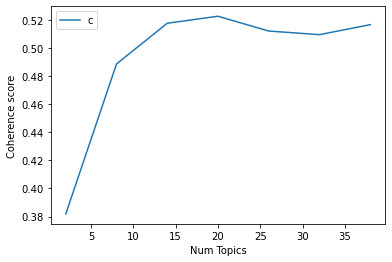

In [23]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
# # Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3818
Num Topics = 8  has Coherence Value of 0.4886
Num Topics = 14  has Coherence Value of 0.5176
Num Topics = 20  has Coherence Value of 0.5226
Num Topics = 26  has Coherence Value of 0.5121
Num Topics = 32  has Coherence Value of 0.5095
Num Topics = 38  has Coherence Value of 0.5166


In [25]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.066*"buy" + 0.055*"order" + 0.046*"cheap" + 0.045*"purchase" + '
  '0.044*"item" + 0.033*"worth" + 0.031*"money" + 0.030*"pay" + 0.022*"amazon" '
  '+ 0.021*"arrive"'),
 (1,
  '0.048*"note" + 0.043*"make" + 0.032*"feel" + 0.030*"small" + 0.026*"stylus" '
  '+ 0.024*"hand" + 0.023*"galaxy" + 0.022*"size" + 0.021*"touch" + '
  '0.019*"find"'),
 (2,
  '0.155*"love" + 0.116*"great" + 0.088*"buy" + 0.071*"recommend" + '
  '0.030*"perfect" + 0.025*"friend" + 0.025*"highly" + 0.023*"cute" + '
  '0.023*"awesome" + 0.020*"purchase"'),
 (3,
  '0.244*"good" + 0.112*"product" + 0.103*"price" + 0.069*"quality" + '
  '0.069*"great" + 0.026*"recommend" + 0.023*"job" + 0.023*"excellent" + '
  '0.021*"easy" + 0.020*"expect"'),
 (4,
  '0.299*"work" + 0.093*"great" + 0.067*"time" + 0.047*"fine" + 0.043*"month" '
  '+ 0.042*"problem" + 0.033*"buy" + 0.030*"long" + 0.025*"year" + '
  '0.020*"couple"'),
 (5,
  '0.210*"battery" + 0.063*"day" + 0.060*"charge" + 0.052*"time" + '
  '0.038*"hour" + 0.0

In [26]:
# Convert to list
data = df.reviewText.values.tolist()

In [27]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Picked up _JAVA_OPTIONS: -Dawt.useSystemAAFontSettings=on -Dswing.aatext=true
Picked up _JAVA_OPTIONS: -Dawt.useSystemAAFontSettings=on -Dswing.aatext=true


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.0883,"good, product, price, quality, great, recommen...",They look good and stick good! I just don't li...
1,1,2.0,0.0972,"love, great, buy, recommend, perfect, friend, ...",These stickers work like the review says they ...
2,2,4.0,0.0692,"work, great, time, fine, month, problem, buy, ...",These are awesome and make my phone look so st...
3,3,0.0,0.1264,"buy, order, cheap, purchase, item, worth, mone...",Item arrived in great time and was in perfect ...
4,4,3.0,0.0669,"good, product, price, quality, great, recommen...","awesome! stays on, and looks great. can be use..."
5,5,0.0,0.0738,"buy, order, cheap, purchase, item, worth, mone...",These make using the home button easy. My daug...
6,6,2.0,0.0744,"love, great, buy, recommend, perfect, friend, ...",Came just as described.. It doesn't come unstu...
7,7,0.0,0.0843,"buy, order, cheap, purchase, item, worth, mone...",it worked for the first week then it only char...
8,8,5.0,0.1273,"battery, day, charge, time, hour, long, life, ...","Good case, solid build. Protects phone all aro..."
9,9,2.0,0.0743,"love, great, buy, recommend, perfect, friend, ...",This is a fantastic case. Very stylish and pro...


In [28]:
all_topics = []

for i in df_dominant_topic['Dominant_Topic'].unique():    
    tmp_1 = df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == i].reset_index()
    tmp_1 = tmp_1.sort_values('Topic_Perc_Contrib', ascending=False).head(1)

    #tmp_1['topic'] = tmp_1['topic'] + 1
    
    tmp_2 = []
    tmp_2.append(tmp_1['topic'].unique()[0])
    tmp_2.append(list(tmp_1['index'].unique()))
    all_topics.append(tmp_2)

all_topics = pd.DataFrame(all_topics, columns=['Dominant_topic', 'topic_name'])
display(all_topics)

KeyError: 'topic'

In [29]:
import pickle
pickle.dump(ldamallet,open('ldamallet.pkl',"wb"))

In [31]:
ldamallet=pickle.load(open("ldamallet.pkl", "rb"))
#tm_results = ldamallet[corpus]